In [0]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0) # фиксируем рандом
np.random.seed(0) 
torch.manual_seed(0)
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True #  cudnn-расчеты на видеокарте

In [58]:
import sklearn.datasets
wine = sklearn.datasets.load_wine() # датасет про вина, в них 13 параметров
df=pd.DataFrame(data=wine.data, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True) # данные отсортированы по таргетам, поэтому перемешаем их 

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [0]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
#         self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
#         self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
#         x = self.fc2(x)
#         x = self.activ2(x)
        x = self.fc3(x) # не прогоняли через softmax,  так как прогоняя через BCE(бин.кросс-энтроп), где есть логарифмы, exp в SM взаимоуничтожатся
        return x

    def inference(self, x): # функция для получения вероятностей, прогоняем через SM
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [76]:
# Тренировка
import random
a=[]
for i in range(11):
  random.seed(i)
  a.append(random.randint(0, 10))
print(a)
print (a.index(5))

[6, 2, 0, 3, 3, 9, 9, 5, 3, 7, 9]
7


In [0]:
loss = torch.nn.CrossEntropyLoss() # формула СE=-sum(t*log(p)), t- таргетное значение, p- функция активации

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [78]:
np.random.permutation(5)

array([0, 3, 1, 2, 4])

In [79]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # для порядка идексов, применимое к датасету
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]# некторые индексы, которые соот-ют некторому batch_size, так как данные могут не помещаться в памяти
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) # пропустим текущую выборку через нейросеть(без SoftMax) и получим некие предсказания
        
        loss_value = loss(preds, y_batch)
        loss_value.backward() # посчитаем производную у loss функии
        
        optimizer.step() # результаты производной передаются к следующему шагу спуска
        
    if epoch % 100 == 0: # каждые 100 эпох мы проверяем обучется ли у нас сеть
        test_preds = wine_net.forward(X_test) # предсказания для тестовой выборки
        test_preds = test_preds.argmax(dim=1) # какой выход был наибольший(не по модулю), тот и будет выходом с максимальной вероятностью
        print((test_preds == y_test).float().mean())# сравниваем с номером класса в y_test и доля совпадения с реальным классом, по сути, это accuracy
        #print(test_preds, test_preds1)

tensor(0.3889)
tensor(0.3519)
tensor(0.4630)
tensor(0.5000)
tensor(0.6111)
tensor(0.6481)
tensor(0.6667)
tensor(0.7222)
tensor(0.7407)
tensor(0.7407)
tensor(0.7222)
tensor(0.7593)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.7778)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)


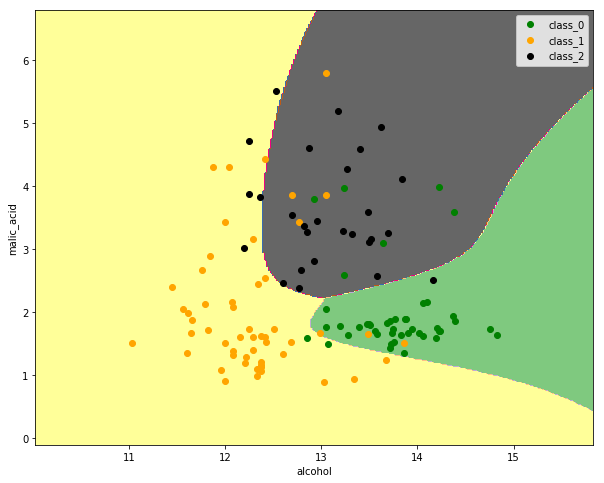

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()